# Inference with Neural Posterior Estimation (NPE)

In [1]:
import os
import pickle
from functools import partial

import numpy as np
import pyabc
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib import pyplot as plt
from tqdm import tqdm

import umap
from sklearn.linear_model import Lasso
import seaborn as sns

from load_bayesflow_model import load_model, custom_loader, EnsembleTrainer
from plotting_routines import plot_posterior_2d
from summary_stats import reduce_to_coordinates, compute_rmse

import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import GenerativeModel, Prior, Simulator

# get the job array id and number of processors
job_array_id = 0 #int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = 10 #int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False

0


In [2]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

# defining the mapping of parameter inside the model xml file. the dictionary name is for 
# parameter name, and the value are the mapping values, to get the map value for parameter 
# check here: https://fitmulticell.readthedocs.io/en/latest/example/minimal.html#Inference-problem-definition

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
sumstat = SummaryStatistics(sum_stat_calculator=partial(reduce_to_coordinates,
                                                        minimal_length=min_sequence_length,
                                                        maximal_length=max_sequence_length,
                                                        only_longest_traj_per_cell=only_longest_traj_per_cell))                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # note: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)


# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis (energy potential)
    'move.strength': 10.,  # strength of directed motion (energy potential)
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # area of the cell  (\mu m^2)
}

obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = ['$m_{\\text{dir}}$', '$m_{\\text{rand}}$', '$w$', '$a$']
log_param_names = ['$\log_{10}(m_{\\text{dir}})$', '$\log_{10}(m_{\\text{rand}})$', '$\log_{10}(w)$', '$\log_{10}(a)$']
print(obs_pars)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.mean': 0.1, 'cell_nodes_real': 50.0}


In [3]:
def prior_fun(batch_size: int) -> np.ndarray:
    samples = []
    for _ in range(batch_size):
        samples.append(list(prior.rvs().values()))
    return np.array(samples)


def generate_population_data(param_batch: np.ndarray, cells_in_population: int, max_length: int) -> np.ndarray:
    """
    Generate population data
    :param param_batch:  batch of parameters
    :param cells_in_population:  number of cells in a population (50)
    :param max_length:  maximum length of the sequence
    :return:
    """
    data_batch = []
    for params in param_batch:
        params_dict = {key: p for key, p in zip(obs_pars.keys(), params)}
        sim = model.sample(params_dict)
        data_batch.append(sim)  # generates a cell population in one experiment

    data_batch_transformed = np.ones((param_batch.shape[0], cells_in_population, max_length, 3)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    for p_id, population_sim in enumerate(data_batch):
        if len(population_sim) == 0:
            # no cells were visible in the simulation
            n_cells_not_visible += 1
            continue
        for c_id, cell_sim in enumerate(population_sim):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_batch_transformed[p_id, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_batch_transformed[p_id, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
            data_batch_transformed[p_id, c_id, -len(cell_sim['t']):, 2] = cell_sim['t']

    if n_cells_not_visible > 0:
        print(f'Simulation with no cells visible: {n_cells_not_visible}/{len(data_batch)}')
    return data_batch_transformed

In [4]:
presimulate = False
presimulation_path = 'presimulations'
n_val_data = 100
cells_in_population = 143
n_params = len(obs_pars)
batch_size = 32
iterations_per_epoch = 100
# 1000 batches to be generated, 10 epochs until the batch is used again
epochs = 500  # 50 effective epochs

# check if gpu is available
print('gpu:', tf.config.list_physical_devices('GPU'))

bayesflow_prior = Prior(batch_prior_fun=prior_fun, param_names=param_names)
bayes_simulator = Simulator(batch_simulator_fun=partial(generate_population_data,
                                                        cells_in_population=cells_in_population,
                                                        max_length=max_sequence_length))
generative_model = GenerativeModel(prior=bayesflow_prior, simulator=bayes_simulator,
                                   skip_test=True,  # once is enough, simulation takes time
                                   name="Normalizing Flow Generative Model")

gpu: []


In [5]:
if presimulate:
    print('presimulating')
    from time import sleep
    sleep(job_array_id)

    # we create on batch per job and save it in a folder
    epoch_id = job_array_id // iterations_per_epoch
    generative_model.presimulate_and_save(
        batch_size=batch_size,
        folder_path=presimulation_path+f'/epoch_{epoch_id}',
        iterations_per_epoch=1,
        epochs=1,
        extend_from=job_array_id,
        disable_user_input=True
    )
    print('Done!')

In [6]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    print('Generating validation data')
    valid_data = generative_model(n_val_data)
    # save the data
    with open(os.path.join(gp, 'validation_data.pickle'), 'wb') as f:
        pickle.dump(valid_data, f)

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)

Mean and std of data: [ 587.005762   1226.92493169 7429.6348269 ] [   51.40666089    60.50555913 11194.06615154]
Mean and std of parameters: [ 1.94728187  0.99232727 -1.42390959  1.33567736] [1.15397718 0.60574734 1.50789037 0.69434402]


In [7]:
model_id = 3 # best: 0, ensemble: 3, only summary: 10
trainer = load_model(
    model_id=model_id,
    x_mean=x_mean,
    x_std=x_std,
    p_mean=p_mean,
    p_std=p_std,
    generative_model=generative_model
)

Loading ensemble model


Final validation loss: -0.7329322099685669


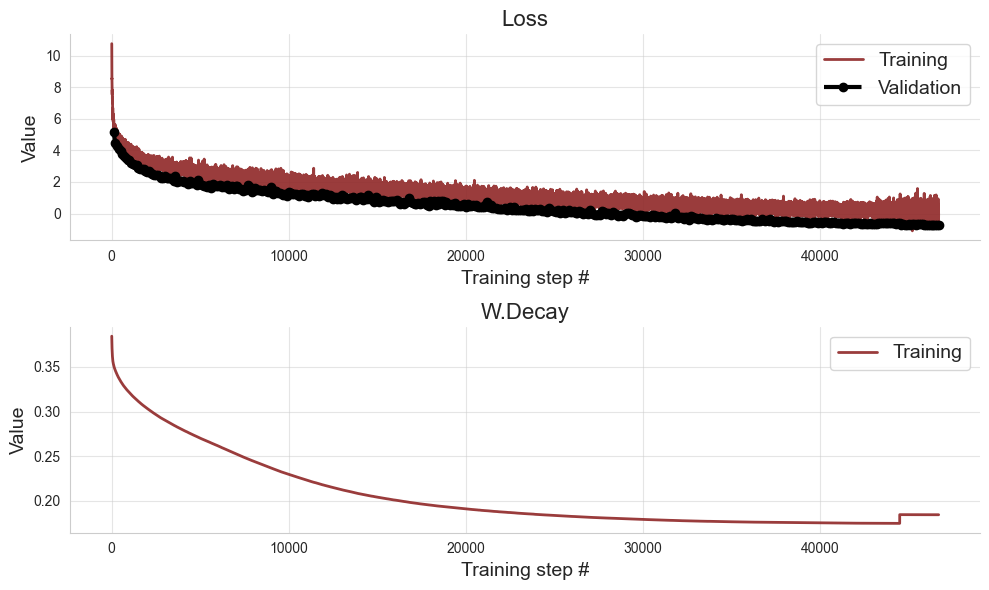

In [8]:
# check if the model is already trained
if not os.path.exists(trainer.checkpoint_path) and not isinstance(trainer, EnsembleTrainer):
    trainer._setup_optimizer(
        optimizer=None,
        epochs=epochs,
        iterations_per_epoch=iterations_per_epoch
    )

    history = trainer.train_from_presimulation(
        presimulation_path=presimulation_path,
        optimizer=trainer.optimizer,
        max_epochs=epochs,
        early_stopping=True,
        early_stopping_args={'patience': 17 - 2},
        custom_loader=custom_loader,
        validation_sims=valid_data
    )
    print('Training done!')
else:
    history = trainer.loss_history.get_plottable()

bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], fig_size=(10, 6))
print('Final validation loss:', np.min(history['val_losses']))

# model 0: -0.6
# model 1: -0.8
# model 2: -0.7

# Diagnostic plots

In [9]:
valid_data_config = trainer.configurator(valid_data)

if isinstance(trainer, EnsembleTrainer):
    prior_draws = valid_data_config[0]["parameters"] * p_std + p_mean
else:
    prior_draws = valid_data_config["parameters"] * p_std + p_mean

RMSE: [0.08230513 0.25126658 0.31664715 0.1602087 ]
RMSE average: 0.2026068909862983


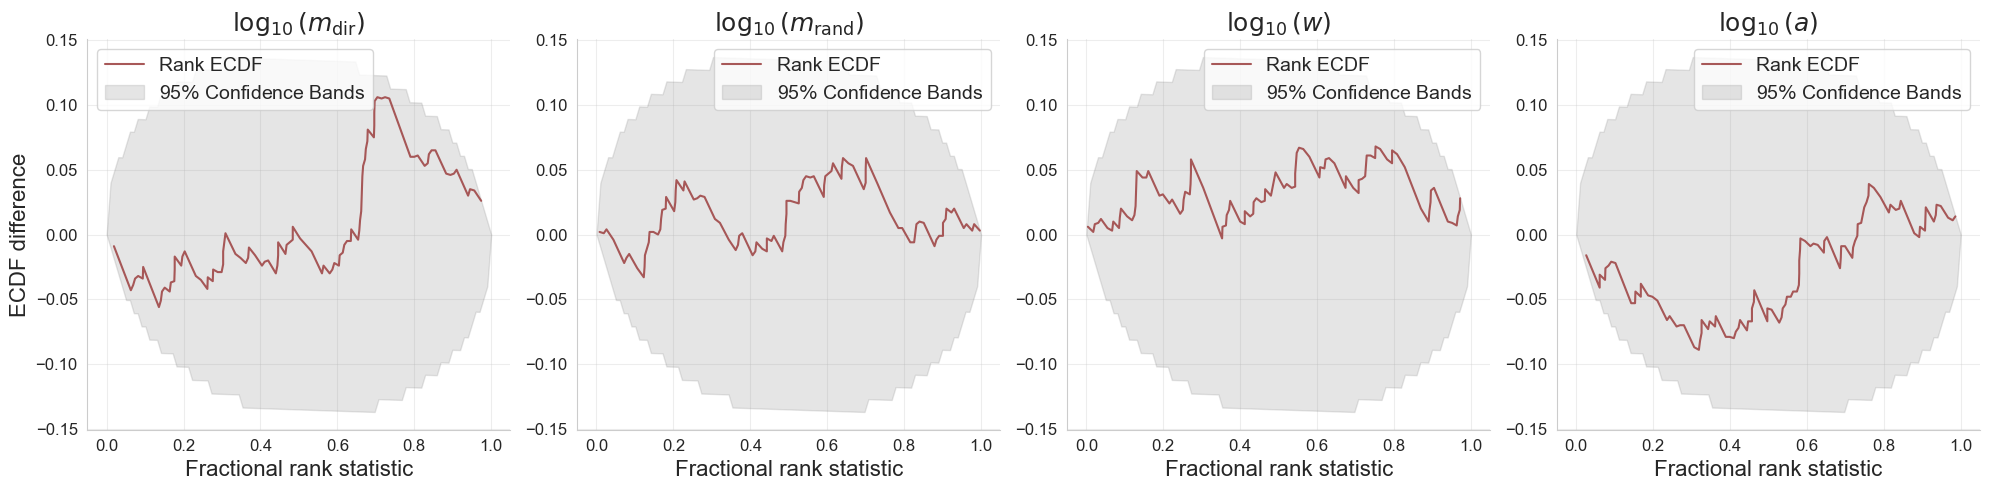

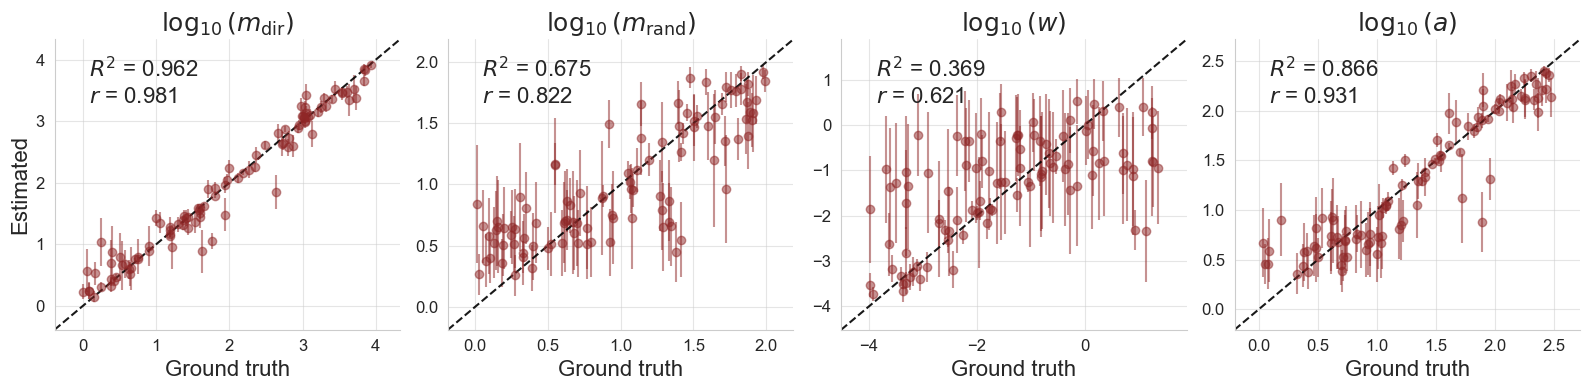

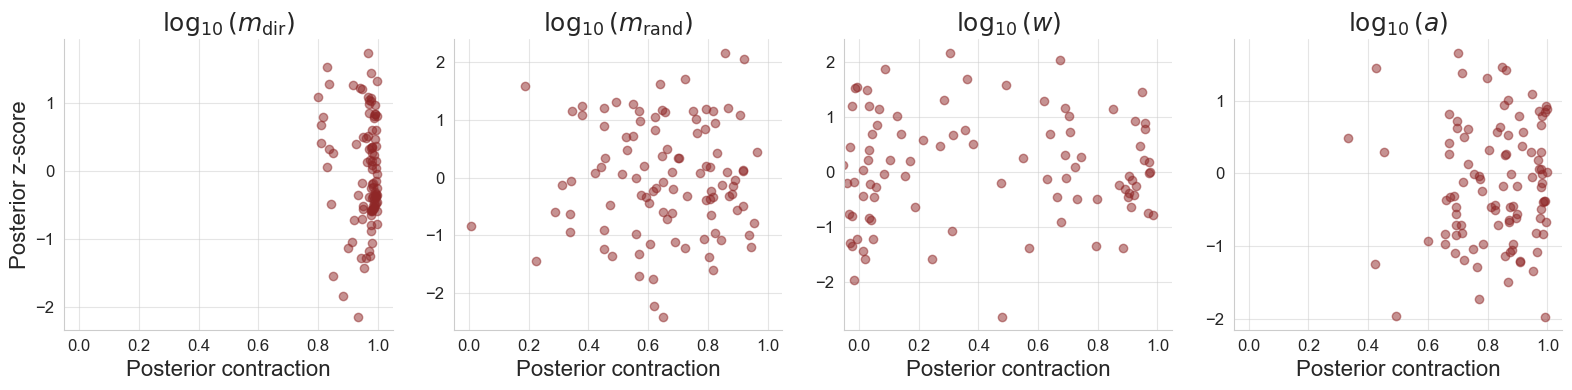

In [10]:
if model_id != 10:
    posterior_samples = trainer.amortizer.sample(valid_data_config, n_samples=1000)
    posterior_samples = posterior_samples * p_std + p_mean

    print('RMSE:', compute_rmse(prior_draws, posterior_samples))
    print('RMSE average:', np.mean(compute_rmse(prior_draws, posterior_samples)))

    # model 0: 0.202
    # model 1: 0.196
    # model 2: 0.208
    # ensemble: 0.202

    bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_draws, difference=True, param_names=log_param_names);
    plt.savefig(f'{trainer.checkpoint_path}/sbc_ecdf.pdf')

    bf.diagnostics.plot_recovery(posterior_samples, prior_draws, param_names=log_param_names);
    plt.savefig(f'{trainer.checkpoint_path}/recovery.pdf')

    bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_draws, param_names=log_param_names);

In [ ]:
# regress summary statistics to parameters to identify the most important latent dimensions
if isinstance(trainer, EnsembleTrainer):
    assert False  # changes the valid_data_config to a list
    summary_output = trainer.amortizer.summary_net(valid_data_config)
    valid_data_config = valid_data_config[0]
else:
    summary_output = trainer.amortizer.summary_net(valid_data_config['summary_conditions'])

if model_id == 10:
    summary_output = summary_output * p_std + p_mean
    fig = bf.diagnostics.plot_recovery(summary_output[:, np.newaxis], prior_draws, param_names=log_param_names)
    plt.savefig(f'{trainer.checkpoint_path}/summary_space_recovery.pdf')
    print('RMSE:', compute_rmse(prior_draws, summary_output[:, np.newaxis]).mean())

# perform a regression of each parameter to the summary statistics
regressors = []
for i in range(valid_data_config['parameters'].shape[1]):
    reg = Lasso(alpha=0.1).fit(summary_output, valid_data_config['parameters'][:, i])
    regressors.append(reg.coef_)

# Convert list of coefficients to a NumPy array for visualization
coeff_matrix = np.array(regressors).T

# Identify the parameter for which each latent dimension is most important
dominant_param = np.argmax(np.abs(coeff_matrix), axis=1)

# Group latent dimensions based on the dominant parameter
grouped_indices = []
for param_idx in range(n_params):
    group = [i for i in range(summary_output.shape[1]) if dominant_param[i] == param_idx]
    grouped_indices.extend(group)

# Reorder the coefficient matrix based on the grouped indices
grouped_coeff_matrix = coeff_matrix[grouped_indices, :]

# Create the heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(
    np.abs(grouped_coeff_matrix).T,
    annot=True,
    cmap=sns.color_palette("flare", as_cmap=True),
    yticklabels=log_param_names,
    xticklabels=[f"Dim {i}" for i in range(summary_output.shape[1])],
    cbar_kws={'label': 'Absolute Coefficient Value'}
)
#plt.title("Regression Coefficients: Latent Dimensions vs Model Parameters")
plt.ylabel("Model Parameters")
plt.xlabel("Latent Dimensions")
plt.savefig(f'{trainer.checkpoint_path}/summary_space_regression_coefficients.pdf', bbox_inches='tight')
plt.show()

# apply a UMAP to the summary statistics
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(summary_output)

fix, ax = plt.subplots(1, n_params, sharey=True, sharex=True, figsize=(12, 3))
for i in range(n_params):
    # color code base on size of parameter
    colors = valid_data['prior_draws'][:, i]
    # min max scaling
    colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
    # map to colormap
    colormap = plt.get_cmap('flare')
    colors = colormap(colors)

    ax[i].scatter(
        embedding[:, 0],
        embedding[:, 1],
        # color code base on size of parameter
        c=colors,
        alpha=0.7,
    )
    ax[i].set_title(f"{log_param_names[i]}")

# add colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=np.min(colors), vmax=np.max(colors)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Normalized Parameter Value')
plt.savefig(f'{trainer.checkpoint_path}/summary_space_umap.pdf')
plt.show()

# Test on synthetic data

In [ ]:
# simulate test data
for test_id in [0, 1, 2]:
    print(test_id)
    np.random.seed(42+test_id)
    test_params = np.array(list(prior.rvs().values()))
    if not os.path.exists(os.path.join(gp, f'test_sim_{test_id}.npy')):
        test_sim_full = bayes_simulator(test_params[np.newaxis])
        test_sim = test_sim_full['sim_data']
        np.save(os.path.join(gp, f'test_sim_{test_id}.npy'), test_sim)
    else:
        test_sim = np.load(os.path.join(gp, f'test_sim_{test_id}.npy'))
        test_sim_full = {'sim_data': test_sim}

    test_posterior_samples = trainer.amortizer.sample(trainer.configurator(test_sim_full), n_samples=1000)
    test_posterior_samples = test_posterior_samples * p_std + p_mean
    test_posterior_samples_median = np.median(test_posterior_samples, axis=0)
    # compute the log posterior of the test data
    input_dict = {
        'sim_data': np.repeat(test_sim, repeats=100, axis=0),
        'parameters': test_posterior_samples
    }

    # save posterior samples to load for abc comparison (only for the best model)
    #np.save(f'abc_results_{test_id}/posterior_samples_npe.npy', test_posterior_samples)

    if not isinstance(trainer, EnsembleTrainer):
        summary_output = trainer.amortizer.summary_net(trainer.configurator(test_sim_full)).numpy().flatten()
        summary_pred = (coeff_matrix.T @ summary_output) * p_std + p_mean
    else:
        summary_pred = None

    fig = plot_posterior_2d(posterior_draws=test_posterior_samples,
                        prior_draws=prior_draws[:test_posterior_samples.shape[0]],
                        param_names=log_param_names,
                        reference_params=summary_pred,
                        true_params=test_params)
    plt.show()

# Real Data

In [11]:
from load_data import load_real_data

wasserstein_distance_dict = {0: np.nan, 1: np.nan}
samples_dict = {0: np.nan, 1: np.nan}
prior_draws = prior_fun(1000)

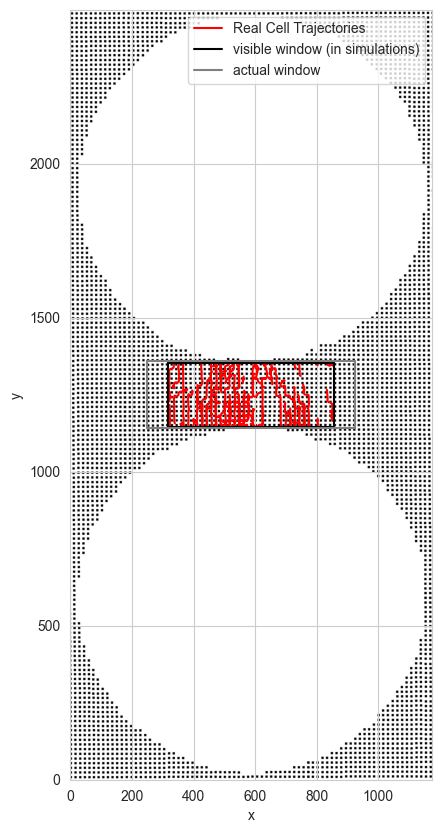

(143, 120, 3)


In [12]:
_, real_data_full = load_real_data(data_id=1,
                                   max_sequence_length=max_sequence_length,
                                   cells_in_population=cells_in_population,
                                   plot_data=True)
print(real_data_full.shape)

Zelldichte macht was aus

Wo wollen Zellen hin? welche parameter beeinflussen das ganze? Zelldichte?

1,5mm

1 (nicht so gut, extrema)
739.79x279.74  microns
20231x768 pixel


2 (wesentlich mehr der Wahrheit)
882.94x287.03 microns
2424x788 pixel


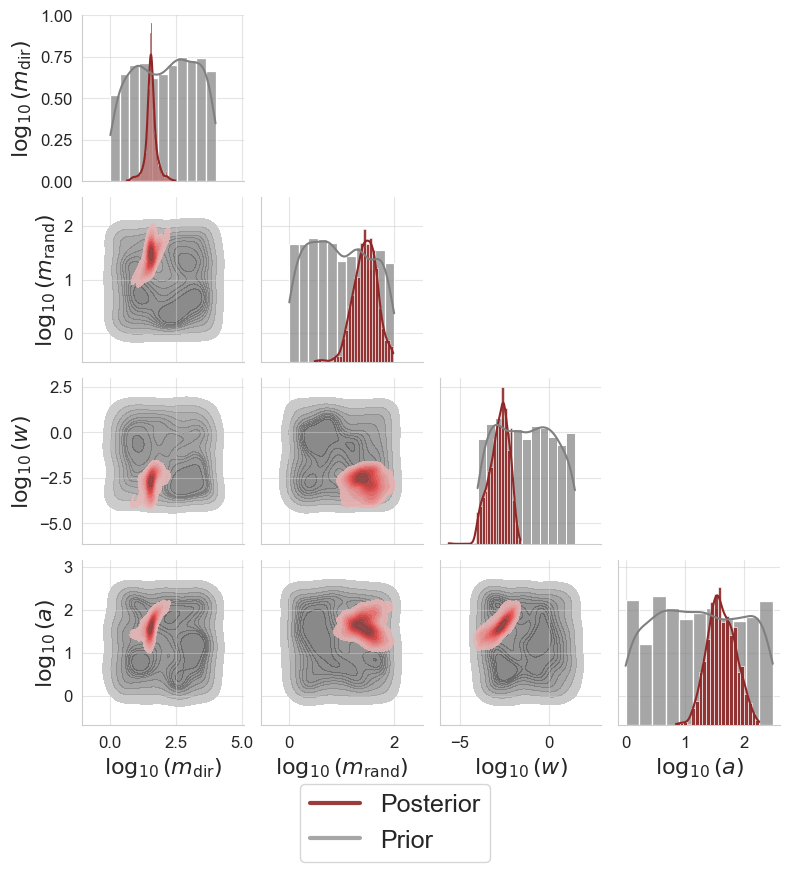

In [13]:
# batch the real data
real_posterior_samples = trainer.amortizer.sample(trainer.configurator({'sim_data': real_data_full[np.newaxis]}),
                                          n_samples=prior_draws.shape[0])
real_posterior_samples = real_posterior_samples * p_std + p_mean

# if isinstance(trainer, EnsembleTrainer):
#     np.save(f'abc_results_real/posterior_samples_npe_ensemble.npy', real_posterior_samples)
# else:
#     np.save(f'abc_results_real/posterior_samples_npe.npy', real_posterior_samples)

fig = plot_posterior_2d(posterior_draws=real_posterior_samples,
                        prior_draws=prior_draws[:real_posterior_samples.shape[0]],
                        param_names=log_param_names)
#plt.savefig(f'{trainer.checkpoint_path}/full_posterior.png')
plt.show()

In [14]:
if isinstance(trainer, EnsembleTrainer):
    log_posteriors = trainer.amortizer.log_posterior(trainer.configurator({'sim_data': real_data_full[np.newaxis]}), n_samples=100)

    # Compute all pairwise row‐differences
    log_posteriors_diffs = log_posteriors[:, None, :] - log_posteriors[None, :, :]

    # Now take the mean over the columns
    log_posteriors_mean = np.mean(log_posteriors_diffs, axis=2)

    # heuristic to check model misspecification
    print('Max KL Divergence:', np.max(log_posteriors_mean))
    print(f'Much smaller than parameter dimension: {np.max(log_posteriors_mean) / len(param_names) < 1}; {np.max(log_posteriors_mean) / len(param_names)}')

100%|██████████| 100/100 [02:12<00:00,  1.32s/it]

Max KL Divergence: 0.32978767
Much smaller than parameter dimension: True; 0.08244691789150238


In [ ]:
if trainer.amortizer.summary_loss is not None:
    from matplotlib.cm import viridis
    real_data_config = trainer.configurator({'sim_data': real_data_full[np.newaxis]})
    summary_statistics = trainer.amortizer.summary_net(valid_data_config['summary_conditions'])
    summary_statistics_obs = trainer.amortizer.summary_net(real_data_config['summary_conditions'])
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    colors = viridis(np.linspace(0.1, 0.9, 2))
    ax.scatter(
        summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
    )
    ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
    ax.legend()
    ax.grid(alpha=0.2)
    plt.gca().set_aspect("equal")
    
    fig.savefig(f'abc_results_real/Real Summary Latent Space.pdf', bbox_inches='tight')
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=real_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'abc_results_real/Real MMD.pdf', bbox_inches='tight')
    plt.show()

# Different Number of Cells in Experiment

In [ ]:
from scipy.stats import linregress
from scipy.stats import median_abs_deviation

In [ ]:
# batch the real data
n_cell_in_batch = np.arange(1, len(real_data_full))
stats_n_cells = {}
np.random.seed(0)

real_posterior_samples_partial = []
real_posterior_samples_artificial = []
for n_cells in tqdm(n_cell_in_batch):
    n_rand_index = np.random.choice(len(real_data_full), size=n_cells, replace=False)
    partial_data = real_data_full[n_rand_index]

    real_posterior_samples = trainer.amortizer.sample(trainer.configurator({'sim_data': partial_data[np.newaxis]}),
                                                      n_samples=100)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_partial.append(real_posterior_samples)

real_posterior_samples_partial = np.stack(real_posterior_samples_partial)

In [ ]:
real_posterior_samples_partial_median = np.median(real_posterior_samples_partial, axis=1)
real_posterior_samples_partial_std = median_abs_deviation(real_posterior_samples_partial, axis=1)

In [ ]:
fig, ax = plt.subplots(1, 4, sharex='row', sharey='col', figsize=(12, 4), tight_layout=True)

for i, p_name in enumerate(log_param_names):
    reg = linregress(n_cell_in_batch, real_posterior_samples_partial_median[:, i])

    ax[i].errorbar(n_cell_in_batch,  real_posterior_samples_partial_median[:, i],
                  yerr=real_posterior_samples_partial_std[:, i],
                  fmt='o',
                  alpha=0.5, label='Estimate (median $\pm$ absolute deviation)' if i == 0 else None)

    reg = linregress(n_cell_in_batch, real_posterior_samples_partial_median[:, i])
    #if reg.pvalue < 0.01:
    ax[i].plot(n_cell_in_batch, reg.slope*n_cell_in_batch + reg.intercept,
                     color='black', label=f'Regression Line' if i == 1 else None,
                   zorder=4)


    ax[i].set_title(f"Correlation {reg.rvalue:.4f}\n(p-value: {reg.pvalue:.4f})")
    ax[i].set_xlabel('Number of Cells')
    ax[i].set_ylabel(f'Median of {log_param_names[i]}')
    ax[i].set_ylim(limits_log[list(limits_log.keys())[i]])

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))
plt.savefig(f'abc_results_real/real_ncells_vs_parameter_median.pdf', bbox_inches='tight')
plt.show()